In [1]:
%config IPCompleter.greedy=True

from sklearn.cluster import AffinityPropagation
import tensorflow as tf
import numpy as np
import cv2
import os
import shutil

from tensorflow import keras
from matplotlib import pyplot as plt

# Mise en place de la caméra

### Recherche de la caméra

In [2]:
!ls -ltrh /dev/video*

crw-rw----+ 1 root video 81, 0 sept. 16 11:14 /dev/video0


### Définition de la classe Camera

In [3]:
import traitlets
import threading
import atexit
import numpy as np


class Camera(traitlets.HasTraits):
    type_camera = traitlets.Unicode("CSI")
    capture_device = traitlets.Integer(default_value=0)
    capture_width = traitlets.Integer(default_value=1280)
    capture_height = traitlets.Integer(default_value=720)
    display_width = traitlets.Integer(default_value=640)
    display_height = traitlets.Integer(default_value=480)
    fps = traitlets.Integer(default_value=30)
    flip = traitlets.Integer(default_value=0)
    image = traitlets.Any()
    video_on = traitlets.Bool(default_value=False)
    
    def __init__(self,*args,**kwargs):
        super(Camera, self).__init__(*args, **kwargs)
        self._running = False
        self.image = np.empty((self.display_height, self.display_width, 3), dtype=np.uint8)
        
        if self.type_camera.find("CSI")>=0:
            self.cap = cv2.VideoCapture(self._gstreamer_pipeline_CSI(),cv2.CAP_GSTREAMER)
        else:
            self.cap = cv2.VideoCapture(self._gstreamer_pipeline_USB(),cv2.CAP_GSTREAMER)

        if self.cap.isOpened():
            print("Caméra initialisée")
        else:
            print("Erreur d'ouverture du flux vidéo")
        atexit.register(self.cap.release)
    
    # Lecture d'une frame
    def capture_image(self):
        re, image = self.cap.read()
        if re:
            image_resized = cv2.resize(image,(int(self.display_width),int(self.display_height)))
        return image_resized
    
    # ON/OFF de la capture vidéo
    def capture_video(self,run=False):
        if run is True:
            self.video_on = True
        else:
            self.video_on = False
    
    # Lecture d'un flux vidéo
    def _capture_video(self):
        while True:
            if not self._running:
                break
            self.image = self.capture_image()

            
    # Détachement de la caméra
    def release(self):
        self.cap.release()

    # Définition du pipeline pour la caméra CSI
    def _gstreamer_pipeline_CSI(self):
        return("nvarguscamerasrc sensor-id=%d ! "
                "video/x-raw(memory:NVMM),"
                "width=(int)%d,height=(int)%d,"
                "format=(string)NV12, framerate=(fraction)%d/1 ! "
                "nvvidconv flip-method=%d ! "
                "video/x-raw,"
                "width=(int)%d,height=(int)%d,"
                "format=(string)BGRx ! videoconvert ! "
                "video/x-raw, format=(string)BGR ! "
                "appsink drop=true"
        %(self.capture_device,self.capture_width,self.capture_height,self.fps,self.flip, self.display_width,self.display_height))

    # Définition du pipeline pour la USB
    def _gstreamer_pipeline_USB(self):
        return("v4l2src device=/dev/video%d ! "
               "video/x-raw, width=(int)%d, height=(int)%d, framerate=(fraction)%d/1 ! "
               "videoflip method=%d ! "
               "videoconvert ! "
               "video/x-raw, format=(string)BGR ! appsink drop=true"
        %(self.capture_device,self.capture_width,self.capture_height,self.fps,self.flip))
    
    # Surveillance de la variable "video_on"
    @traitlets.observe('video_on')
    def _on_running(self, change):
        if change['new'] and not change['old']:
            # not running -> running
            self._running = True
            self.thread = threading.Thread(target=self._capture_video)
            self.thread.start()
        elif change['old'] and not change['new']:
            # running -> not running
            self._running = False
            self.thread.join()

### Instanciation de la classe Camera

In [4]:
def InitCamera():
    camera = Camera(type_camera="USB",capture_device=0,
                capture_width=640,capture_height=480,
                display_width=224,display_height=224,
                fps=30,flip=0)
    return camera

# Création des données d'entrainement

### Acquisition des images

On commence par créer une interface à l'aide des widgets permettant de récupérer les données et de les sauvegarder dans un dictionnaire :

In [5]:
def bgr8_to_jpeg(value, quality=75):
    return bytes(cv2.imencode('.jpg', value)[1])

In [6]:
TACHE = "visage"
CATEGORIES = ['nez']

datasets = {}
for name in CATEGORIES:
    datasets[name] = []

In [7]:
# Initialise la caméra
try :
    camera.capture_video(run=False)
    camera.release()
    del camera
except NameError:
    pass

camera = InitCamera()

Caméra initialisée


In [ ]:
import ipywidgets
import traitlets
from IPython.display import display
import urllib3
from jupyter_clickable_image_widget import ClickableImageWidget

# Initialise la caméra
try :
    camera.capture_video(run=False)
    camera.release()
    del camera
except NameError:
    pass

camera = InitCamera()

# Création du widget "cliquable" de la vidéo
camera_widget = ClickableImageWidget(width=camera.display_width,height=camera.display_height)
camera_widget.add_class('classe_camera')
traitlets.dlink((camera, 'image'), (camera_widget, 'value'), transform=bgr8_to_jpeg)

# Création du widget de visualisation de la capture de l'image
url = "https://github.com/AlexandreBourrieau/JetsonNano/blob/main/images/ready_img.jpg?raw=true"
http = urllib3.PoolManager()
image = http.request("GET",url)
image = np.asarray(bytearray(image.data), dtype="uint8")
image = cv2.imdecode(image, cv2.IMREAD_COLOR)
image = cv2.resize(image,(int(camera.display_width),int(camera.display_height)))

capture_widget = ipywidgets.Image(value=image.tobytes(),width=camera.display_width,height=camera.display_height)

# Création des widgets de l'interface
category_widget = ipywidgets.Dropdown(options=CATEGORIES, description='Catégorie')
count_widget = ipywidgets.IntText(description='Nombre')

# Mise à jour du nombre de données dans les catégories
def update_counts(change):
    count_widget.value = len(datasets[change['new']])
count_widget.value = len(datasets[category_widget.value])
category_widget.observe(update_counts, names='value')

# Prise d'une image
def save(_,content,msg):
    if content['event'] == 'click':
        # Récupère les coordonnées (X,Y) du clic
        data = content['eventData']
        x = data['offsetX']
        y = data['offsetY']
        
        # Sauvegarde de l'image et des coordonnées
        datasets[category_widget.value].append([camera.image,x,y])

        # Affiche la capture de l'image avec la zone du clic
        capture_image = camera.image.copy()
        capture_image = cv2.circle(capture_image, (x,y), 8, (0,255,0), 3)
        capture_widget.value = bgr8_to_jpeg(capture_image)
        
        # Mise à jour du compteur d'image
        count_widget.value = len(datasets[category_widget.value])
camera_widget.on_msg(save)

data_collection_widget = ipywidgets.VBox([
    ipywidgets.HBox([camera_widget,capture_widget]), category_widget, count_widget])

# Lancement de la vidéo
camera.capture_video(run=True)
camera_link = traitlets.dlink((camera, 'image'), (camera_widget, 'value'), transform=bgr8_to_jpeg)

# Affiche l'interface
display(data_collection_widget)

In [ ]:
datasets

### Sauvegarde des images

Les données sont sauvegardées en respectant la structure requise par la fonction tf.keras.preprocessing.image_dataset_from_directory : https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

In [8]:
repertoire_courant = os.getcwd()

In [ ]:
# Création des répertoires de sauvegarde
try:
    shutil.rmtree(repertoire_courant+"/projet_regression/"+TACHE)
except FileNotFoundError:
    pass

for i in range(len(CATEGORIES)):
    try:
        shutil.rmtree(repertoire_courant+"/projet_regression/"+TACHE+"/"+CATEGORIES[i])
    except FileNotFoundError:
        pass
    os.makedirs(repertoire_courant+"/projet_regression/"+TACHE+"/"+CATEGORIES[i])

In [ ]:
# Enregistrement des images
for i in range (len(CATEGORIES)):
    n = 0
    for image,x,y in datasets[CATEGORIES[i]]:
        n = n+1
        cv2.imwrite(repertoire_courant+"/projet_regression/"+TACHE+"/"+CATEGORIES[i]+"/"+CATEGORIES[i]+"_image_%d_%d_%d.jpg" %(n,x,y),image)

# Création des datasets

### 1. Chargement des images dans le dataset de classification

A partir des images sauvegardées dans le répertoire de travail, on peut maintenant créer notre dataset :

In [9]:
batch_size = 2
dataset_entrainement = tf.keras.preprocessing.image_dataset_from_directory(
    repertoire_courant+"/projet_regression/"+TACHE,
    validation_split=0.0,
    batch_size=batch_size,
    label_mode="categorical")

Found 20 files belonging to 1 classes.


In [10]:
class_names = dataset_entrainement.class_names
print(class_names)

['nez']


Affichons quelques labels codé de manière "categorical" et leur valeur équivalente "binaire" :

In [11]:
for image,label in dataset_entrainement.take(1):
    print(image.shape)
    print(label.shape)

(2, 256, 256, 3)
(2, 1)


Récupérons maintenant les répertoires associés aux images du dataset :

In [12]:
repertoires_images = dataset_entrainement.file_paths
#repertoires_images

In [13]:
dataset_entrainement.class_names

['nez']

### 2. Modification du dataset d'entrainement en type regression

On va transformer le dataset de la manière suivante :

<img src="https://github.com/AlexandreBourrieau/JetsonNano/blob/main/images/datset_regression_heatmap2.png?raw=true" width=400>

Commençons par vérifier la correspondance des labels :

In [ ]:
# nez :         [1 0 0] => label binaire : 0

for image,label in dataset_entrainement.take(16):
    print("Label categorical : %s" %label[0])
    print("Label binaire correspondant : %s" %np.argmax(label[0], axis=None, out=None))
    print("Classe correspondante : %s" %class_names[np.argmax(label[0], axis=None, out=None)])
    print("")

##### a. Création des heatmap

On commence par définir la fonction permettant de créer le heatmap :

$K\left( {x,y} \right) = \exp \left( { - \frac{{{{\left( {x - {x_0}} \right)}^2}}}{{2\sigma _x^2}} - \frac{{{{\left( {y - {y_0}} \right)}^2}}}{{2\sigma _y^2}}} \right)$

In [15]:
alpha = 0.2
sigma_x = alpha*camera.display_width/6.0
sigma_y = alpha*camera.display_height/6.0

def CreateHeatmap(x, y, x0, y0):
    return np.exp(-((x - x0)**2. / (2. * sigma_x**2.) + (y - y0)**2. / (2. * sigma_y**2.)))

Voici un exemple de heatmap basé sur une image en entrée de (224,224) puis réduit en sortie d'un coefficient de (1/4) avec l'opération de max_pooling :

In [16]:
from imgaug.augmentables.heatmaps import HeatmapsOnImage

x0 = 50
y0 = 100
x,y = np.meshgrid(np.linspace(0,camera.display_width-1,camera.display_width), np.linspace(0,camera.display_height-1,camera.display_height))
z = CreateHeatmap(x,y,x0,y0).astype(np.float32)

z = HeatmapsOnImage(z, (camera.display_width,camera.display_height), min_value=0.0, max_value=1.0)
z = z.max_pool(4)

In [17]:
z

In [18]:
tf.convert_to_tensor(z.get_arr()).shape

TensorShape([56, 56, 1])

In [19]:
z.get_arr()

array([[[0.000000e+00],
        [1.401298e-44],
        [2.676480e-43],
        ...,
        [0.000000e+00],
        [0.000000e+00],
        [0.000000e+00]],

       [[5.114739e-43],
        [1.291016e-41],
        [2.446009e-40],
        ...,
        [0.000000e+00],
        [0.000000e+00],
        [0.000000e+00]],

       [[3.501523e-40],
        [8.839643e-39],
        [1.674847e-37],
        ...,
        [0.000000e+00],
        [0.000000e+00],
        [0.000000e+00]],

       ...,

       [[0.000000e+00],
        [0.000000e+00],
        [0.000000e+00],
        ...,
        [0.000000e+00],
        [0.000000e+00],
        [0.000000e+00]],

       [[0.000000e+00],
        [0.000000e+00],
        [0.000000e+00],
        ...,
        [0.000000e+00],
        [0.000000e+00],
        [0.000000e+00]],

       [[0.000000e+00],
        [0.000000e+00],
        [0.000000e+00],
        ...,
        [0.000000e+00],
        [0.000000e+00],
        [0.000000e+00]]], dtype=float32)

In [20]:
tf.math.reduce_max(tf.convert_to_tensor(z.get_arr()))

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

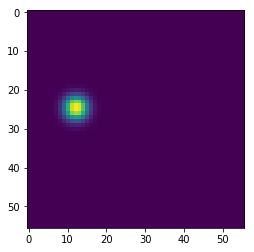

In [21]:
plt.imshow(z.get_arr()[:,:,0])

##### b. Création des dataset pour la régression

On définit maintenant une fonction pour créer notre dataset pour la régression. Il faut prendre en compte le fait que le heatmap doit être réduit à la dimension de sortie des images créées par le modèle.  
On choisit un coefficient de réduction de (1/4).

In [22]:
from imgaug.augmentables.heatmaps import HeatmapsOnImage

# Fonction de création du dataset d'entrainement
# à partir de la liste des fichiers contenus dans
# le dataset de classification

# /home/alexandre/projet_regression/visage/oeil_droit/oeil_droit_image_6_217_181.jpg

def CreationDatasetRegression(liste_fichiers,noms_classes):
    heatmap_ = [[] for i in range(len(noms_classes))]
    images_= []

    width = camera.display_width
    height = camera.display_height

    # Création du heatmap nul
    heatmap_zero = np.zeros((height,width)).astype(np.float32)
    heatmap_zero = HeatmapsOnImage(heatmap_zero, shape=(height,width), min_value=0.0, max_value=1.0)
    heatmap_zero = heatmap_zero.avg_pool(4)

    # Création de la grille pour le heatmap
    x,y = np.meshgrid(np.linspace(0,width-1,width), np.linspace(0,height-1,height))
    
    # Définition des constantes pour le heatmap
    alpha = 0.2
    sigma_x = alpha*camera.display_width/6.0
    sigma_y = alpha*camera.display_height/6.0
    
    # Conversion des classe du heatmap zero en tenseur 1D
    # (56,56,nbr_classes)
    heatmap_zero = tf.convert_to_tensor(heatmap_zero.get_arr())

    for fichier in liste_fichiers:
        # Chargement de l'image
        image = tf.keras.preprocessing.image.load_img(fichier)
        image = tf.keras.preprocessing.image.img_to_array(image)

        # Extraction des coordonnées (x0,Y0)
        # correspondantes aux dimensions de l'image chargée (height,width)
        element = tf.strings.split(fichier,sep="_image_")
        element = tf.strings.split(element[1],sep="_")
        x0 = tf.strings.to_number(element[1],out_type=tf.dtypes.float32)
        y0 = tf.strings.split(element[2],sep=".")
        y0 = tf.strings.to_number(y0[0],out_type=tf.dtypes.float32)
        
        # Extraction de la classe
        classe = tf.strings.split(fichier,sep="/")[-2]
        
        # Extraction du label
        label = tf.cast(tf.strings.regex_full_match(noms_classes, classe),dtype="int32")
        
        # Extraction de la valeur binaire du label
        maxi = tf.math.argmax(label,output_type=tf.dtypes.int32)
        
        # Création du heatmap de l'image
        heatmap = CreateHeatmap(x,y,x0,y0).astype(np.float32)
        heatmap = HeatmapsOnImage(heatmap, (height,width,1), min_value=0.0, max_value=1.0)
        heatmap = heatmap.max_pool(4)
        
        # Sauvegarde du heatmap et de l'image dans les listes
        for i in range(len(noms_classes)):
            if i == maxi:
                heatmap = tf.convert_to_tensor(heatmap.get_arr())
                heatmap_[i].append(heatmap)
            else:
                heatmap_[i].append(heatmap_zero)
        images_.append(image)
   
    # Création du dataset
    images_ = tf.convert_to_tensor(images_)                                # (nbr_images,H,W,3)
    heatmap_ = tf.convert_to_tensor(heatmap_)                              # (nbr_images,H/4,W/4,1)
    heatmap_ = tf.transpose(heatmap_,perm=[1,2,3,0,4])                     # (nbr_image,H/4,W/4)
    heatmap_ = tf.squeeze(heatmap_,-1)                                     # (nbr_image,H/4,W/4)

    datasetHeatmap = tf.data.Dataset.from_tensors(heatmap_)                # (nbr_images,3,H/4,W/4)
    datasetImg = tf.data.Dataset.from_tensors(images_)                     # (nbr_images,H,W,3) 
    dataset = tf.data.Dataset.zip((datasetImg,datasetHeatmap))

    return (dataset)

On créé notre dataset :

In [23]:
dataset_regression = CreationDatasetRegression(repertoires_images,dataset_entrainement.class_names)

In [24]:
for image,heatmap in dataset_regression.take(1):
    print(image.shape)
    print(heatmap.shape)

(20, 224, 224, 3)
(20, 56, 56, 1)


On redimensionne le dataset au bon batch_size :

In [25]:
dataset_regression = dataset_regression.unbatch()
dataset_regression = dataset_regression.batch(batch_size)

In [26]:
for image,heatmap in dataset_regression.take(1):
    print(image.shape)
    print(heatmap.shape)

(2, 224, 224, 3)
(2, 56, 56, 1)


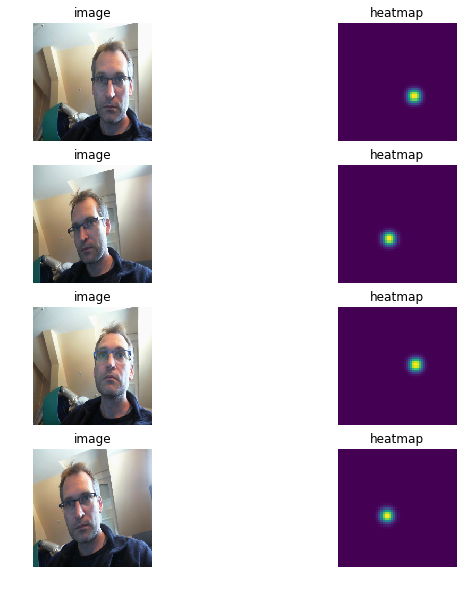

In [27]:
iterator = iter(dataset_regression.unbatch())

plt.figure(figsize=(10, 10))
for i in range(4):
    image, heatmap = iterator.get_next()
    ax = plt.subplot(4, 2, 2*i+1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("image")
    plt.axis("off")
    ax = plt.subplot(4, 2, 2*i+2)
    plt.imshow(heatmap[:,:,0])
    plt.title("heatmap")
    plt.axis("off")

### Traitement des images

##### Resnet18

Pas de pré-traitement avec le modèle Restnet18 utilisé.

# Création du modèle

### Modèle de regression basé sur Restnet18

In [ ]:
from CreateRegressionModel import GetRegressionModel

In [ ]:
# Chargement du modèle de régression
base_model = GetRegressionModel(image_width=camera.display_width,image_height=camera.display_height,n_labels=len(class_names))
base_model.summary()

In [ ]:
# Désactivation des couches poru l'entrainement
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Liste des couches du modèle
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

In [ ]:
for layer in base_model.layers[82:]:
   layer.trainable = True

base_model.summary()

# Entrainement du modèle

### Création de la fonction d'erreur

##### MSE : Mean Squared Error (Erreur Quadradique Moyenne)

L'erreur quadratique moyenne correspond au calcul de l'écart type :

$mse = \frac{1}{N}\sum\limits_{i \in H,W} {{{\left( {{y_i} - {{\hat y}_i}} \right)}^2}}$

N : Nombre total de pixel du heatmap  
H : Hauteur ; W : Largeur ;  
${y_i}$ : Vraie valeur du pixel du heatmap  
${{\hat y}_i}$ : Prédiction de la valeur du pixel du heatmap


In [ ]:
def erreur_mse(y_true,y_predict):
    return tf.keras.losses.mse(y_true,y_predict)

##### MAE : Mean Absolute Error (Erreur Absolue Moyenne)

L'erreur absolue moyenne est la moyenne des valeurs absolues des erreurs :

$mae = \frac{1}{N}\sum\limits_{i \in H,W} {\left| {{y_i} - {{\hat y}_i}} \right|}$

N : Nombre total de pixel du heatmap  
H : Hauteur ; W : Largeur ;  
${y_i}$ : Vraie valeur du pixel du heatmap  
${{\hat y}_i}$ : Prédiction de la valeur du pixel du heatmap

In [ ]:
def erreur_mae(y_true,y_predict):
    return tf.keras.losses.mae(y_true,y_predict)

##### Focal loss : Erreur focale

Cette erreur est spécifiquement utilisé dans la détection d'image :

$focal = \sum\limits_{i \in H,W} {\left\{ \begin{array}{l}
{\left( {1 - {{\hat y}_i}} \right)^\alpha }\log \left( {{{\hat y}_i}} \right){\rm{\quad \quad \quad \quad \ si \ }}{y_i}{\rm{ = 1 }}\\
{\left( {1 - {y_i}} \right)^\beta }{{\hat y}_i}^\alpha \log \left( {1 - {{\hat y}_i}} \right){\rm{\qquad sinon}}
\end{array} \right.}$

$\alpha$ et $\beta$ sont des hyperparamètres. Souvent on prend : $\alpha$ = 4.0 et $\beta$ = 2.0

Plus de détails dans ce document de recherche :https://arxiv.org/pdf/1708.02002.pdf

In [ ]:
def erreur_focal_loss(y_true,y_predict):
    pos_mask = tf.cast(tf.equal(y_true, 1.0), dtype=tf.float32)
    neg_mask = tf.cast(tf.less(y_true, 1.0), dtype=tf.float32)
    neg_weights = tf.pow(1.0 - y_true, 4)

    pos_loss = -tf.math.log(tf.clip_by_value(y_predict, 1e-5, 1.0 - 1e-5)) * tf.math.pow(1.0 - y_predict, 2.0) * pos_mask
    neg_loss = (
        -tf.math.log(tf.clip_by_value(1.0 - y_predict, 1e-5, 1.0 - 1e-5))
        * tf.math.pow(y_predict, 2.0)
        * neg_weights
        * neg_mask
    )

    num_pos = tf.reduce_sum(pos_mask)
    pos_loss = tf.reduce_sum(pos_loss)
    neg_loss = tf.reduce_sum(neg_loss)

    loss = tf.cond(tf.greater(num_pos, 0), lambda: (pos_loss + neg_loss) / num_pos, lambda: neg_loss)
    return loss

### Entrainement du modèle

In [ ]:
# Nombre de périodes d'entrainement
periodes = 15

# Entrainement du modèle
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
base_model.compile(optimizer=opt, loss=erreur_mae)
base_model.fit(dataset_regression,verbose=1,epochs=periodes)

# Analyse des résultats

### Interface de capture d'image

In [ ]:
import ipywidgets
import traitlets
from IPython.display import display
import urllib3
from jupyter_clickable_image_widget import ClickableImageWidget
# Initialise la caméra
try :
    camera.capture_video(run=False)
    camera.release()
    del camera
except NameError:
    pass

camera = InitCamera()

# Création du widget "cliquable" de la vidéo
camera_widget = ClickableImageWidget(width=camera.display_width,height=camera.display_height)
camera_widget.add_class('classe_camera')
traitlets.dlink((camera, 'image'), (camera_widget, 'value'), transform=bgr8_to_jpeg)


# Lancement de la vidéo
camera.capture_video(run=True)
camera_link = traitlets.dlink((camera, 'image'), (camera_widget, 'value'), transform=bgr8_to_jpeg)

# Prise d'une image
def save(_,content,msg):
    global image_test
    if content['event'] == 'click':
        image_test = camera.image
camera_widget.on_msg(save)

display(camera_widget)

In [ ]:
plt.imshow(image_test)

### Prédiciton du heatmap avec le modèle

In [ ]:
predict_heat = base_model(tf.expand_dims(image_test,0))
predict_heat.shape

In [ ]:
plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 2, 1)
plt.imshow(image_test)
plt.title("image")
plt.axis("off")
ax = plt.subplot(1, 2, 2)
plt.imshow(predict_heat[0,:,:,0])
plt.title("heatmap")
plt.axis("off")

### Principe de récupération des coordonnées de la cible

On commence par traiter le heatmap afin d'accentuer les zones à fortes valeurs. Pour cela :
- On applique une opération de MaxPooling sur le heatmap, ce qui va élargir un petit peu les zones à fortes valeurs
- On vient ensuite masquer le résultat du MaxPooling avec le heatmap original afin de ne garder que les valeurs en commun
- On applique le résultat obtenu pour filtrer le MaxPooling

In [ ]:
hmax = tf.keras.layers.MaxPooling2D(3, 1, padding="same")(predict_heat)
keep = tf.cast(tf.equal(predict_heat, hmax), tf.float32)
prod = hmax*keep

In [ ]:
plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 5, 1)
plt.imshow(image_test)
plt.title("image")

ax = plt.subplot(1, 5, 2)
plt.imshow(predict_heat[0,:,:,0])
plt.title("heatmap")

ax = plt.subplot(1, 5, 3)
plt.title("MaxPooling")
plt.imshow(hmax[0,:,:,0])

ax = plt.subplot(1, 5, 4)
plt.title("masquage")
plt.imshow(keep[0,:,:,0])

ax = plt.subplot(1, 5, 5)
plt.title("produit")
plt.imshow(prod[0,:,:,0])

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

sh_0, sh_1 = predict_heat[0,:,:,0].shape
x, y = np.linspace(0, sh_0-1, sh_0), np.linspace(0, sh_1-1, sh_1)

fig = go.Figure(data=[go.Surface(z=predict_heat[0,:,:,0], x=x, y=y)])
fig.update_layout(autosize=False,
                  scene_camera_eye=dict(x=1.87, y=0.88, z=-0.64),
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90)
)

fig.show()

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

sh_0, sh_1 = predict_heat[0,:,:,0].shape
x, y = np.linspace(0, sh_0-1,sh_0), np.linspace(0, sh_1-1,sh_1)

fig = go.Figure(data=[go.Surface(z=hmax[0,:,:,0], x=x, y=y)])
fig.update_layout(autosize=False,
                  scene_camera_eye=dict(x=1.87, y=0.88, z=-0.64),
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90)
)

fig.show()

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

sh_0, sh_1 = predict_heat[0,:,:,0].shape
x, y = np.linspace(0, sh_0-1, sh_0), np.linspace(0, sh_1-1, sh_1)

fig = go.Figure(data=[go.Surface(z=keep[0,:,:,0], x=x, y=y)])
fig.update_layout(autosize=False,
                  scene_camera_eye=dict(x=1.87, y=0.88, z=-0.64),
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90)
)

fig.show()

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

sh_0, sh_1 = predict_heat[0,:,:,0].shape
x, y = np.linspace(0, sh_0-1, sh_0), np.linspace(0, sh_1-1, sh_1)

fig = go.Figure(data=[go.Surface(z=prod[0,:,:,0], x=x, y=y)])
fig.update_layout(autosize=False,
                  scene_camera_eye=dict(x=1.87, y=0.88, z=-0.64),
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90)
)

fig.show()

On vient ensuite récupérer les index des pixels les plus forts avec la méthode https://www.tensorflow.org/api_docs/python/tf/math/top_k à partir du résultat applati :

In [ ]:
prod_applati = tf.reshape(prod, (1, -1))
prod_applati.shape

In [ ]:
scores, index = tf.nn.top_k(prod_applati, k=1)
print(scores)
print(index)

In [ ]:
x = np.linspace(0, prod_applati[0,:].shape[0]-1, prod_applati[0,:].shape[0])

plt.plot(x,np.asarray(prod_applati[0,:]))

Ensuite il faut convertir les coordonnées dans l'espace (X,Y) :

In [ ]:
xs = tf.cast(index % predict_heat[0,:,:,0].shape[1], tf.float32)
ys = tf.cast(index // predict_heat[0,:,:,0].shape[0], tf.float32)

print(xs)
print(ys)

In [ ]:
plt.figure(figsize=(5, 5))
plt.imshow(image_test)
plt.plot(xs*4,ys*4,'bo')
plt.title("image")

# Expérimentations

### Création de la fonction extraction des coordonnées

In [ ]:
def GetCoordFromHeatmap(heatmap,sampling=4):
    hmax = tf.keras.layers.MaxPooling2D(3, 1, padding="same")(heatmap)
    keep = tf.cast(tf.equal(heatmap, hmax), tf.float32)
    prod = hmax*keep

    # Applatissement
    prod_applati = tf.reshape(prod, (1, -1))
    
    # Récupère les index du maximum
    scores, index = tf.nn.top_k(prod_applati, k=1)
    
    # Calcul des coordonnées
    xs = tf.cast(index % heatmap[0,:,:,0].shape[1], tf.float32)
    ys = tf.cast(index // heatmap[0,:,:,0].shape[0], tf.float32)
    return xs*sampling,ys*sampling

### Création de l'interface d'acquisition

In [ ]:
import ipywidgets
import traitlets
from IPython.display import display

# Initialise la caméra
try :
    camera.capture_video(run=False)
    camera.release()
    del camera
except NameError:
    pass

camera = InitCamera()

# Création du widget de la vidéo
camera_widget = ipywidgets.Image()
traitlets.dlink((camera, 'image'), (camera_widget, 'value'), transform=bgr8_to_jpeg)

# Lancement de la vidéo
camera.capture_video(run=True)
camera_link = traitlets.dlink((camera, 'image'), (camera_widget, 'value'), transform=bgr8_to_jpeg)

# Création des widgets
state_widget = ipywidgets.ToggleButtons(options=['stop', 'live'], description='state', value='stop')
category_widget = ipywidgets.Dropdown(options=CATEGORIES, description='Catégorie')
preview_widget = ipywidgets.Image(format="jpeg",width=camera.display_width, height=camera.display_height, value=bgr8_to_jpeg(camera.image))

# Fonction de traitement des actions du widget "state_widget"
def live(state_widget, model, camera):
    while state_widget.value == 'live':
        # Capture de l'image
        image = camera.image
       
        # Récupération de la catégorie
        categorie = CATEGORIES.index(category_widget.value)

        # Prédiciton de la heatmap
        heatmap = model(tf.expand_dims(image,0))
        x,y = GetCoordFromHeatmap(heatmap)
   
        prediction = image.copy()
        prediction = cv2.circle(prediction, (x, y), 8, (255, 0, 0), 3)
        preview_widget.value = bgr8_to_jpeg(prediction)
       
def start_live(change):
    if change['new'] == 'live':
        global execute_thread
        execute_thread = threading.Thread(target=live, args=(state_widget, base_model, camera))
        execute_thread.start()
    else:
        execute_thread.join()
       
state_widget.observe(start_live, names='value')

data_collection_widget = ipywidgets.VBox([
    ipywidgets.HBox([camera_widget,preview_widget]),category_widget,state_widget])


display(data_collection_widget)